# Analysing Permissions and Trackers of the mHealth Apps

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

mhealth_apps = pd.read_csv("../data/mhealth_apps.csv")

In [2]:
usa = ['us']

# source: https://www.gdpradvisor.co.uk/gdpr-countries
GDPR_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 
                  'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
                  'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']

country_list = pd.read_csv("../data/country_list.csv")

europe = []

for country in GDPR_countries:
    matching_countries = country_list[country_list['country_name'].str.contains(country, na=False)]
    europe.extend(matching_countries['country_code'].tolist())

print(len(europe)-1)
print(europe)

28
['at', 'be', 'bg', 'hr', 'cy', 'cz', 'dk', 'ee', 'fi', 'fr', 'de', 'gr', 'hu', 'ie', 'it', 'lv', 'lt', 'lu', 'mt', 'nl', 'pl', 'pt', 'ro', 'sk', 'si', 'es', 'se', 'uk', 'gb']


In [3]:
def extract_unique_item(dataframe):
    unique_items = set()
    for items in dataframe.dropna():
        unique_items.update(str(items).split(", "))
    return unique_items

def filter_data(df):

    def country_filter(countries, country_set):
        return any(country.lower() in country_set for country in countries)

    countries_list = df['countries'].str.split(', ').explode()
    usa_europe = set(usa + europe)
    rest_of_world = set(countries_list) - usa_europe
    
    df['country_split'] = df['countries'].str.split(', ')
    us_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, usa))]
    europe_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, europe))]
    row_filtered_df = df[df['country_split'].apply(lambda x: country_filter(x, rest_of_world))]

    print('Number of apps available in USA:', len(us_filtered_df))
    print('Number of apps available in Europe:', len(europe_filtered_df))
    print('Number of apps available in RoW:', len(row_filtered_df))
    
    return us_filtered_df, europe_filtered_df, row_filtered_df

In [4]:
usa_df, europe_df, rest_of_world_df = filter_data(mhealth_apps)


Number of apps available in USA: 360
Number of apps available in Europe: 389
Number of apps available in RoW: 832


# Permissions

In [5]:
usa_permissions = extract_unique_item(usa_df['permissions'])
europe_permissions = extract_unique_item(europe_df['permissions'])
rest_of_world_permissions = extract_unique_item(rest_of_world_df['permissions'])

usa_dangerous_permissions = extract_unique_item(usa_df['dangerous_permissions'])
europe_dangerous_permissions = extract_unique_item(europe_df['dangerous_permissions'])
rest_of_world_dangerous_permissions = extract_unique_item(rest_of_world_df['dangerous_permissions'])

print(f'Total unique permission in US: {len(usa_permissions)}')
print(f'Total dangerous permission in US: {len(usa_dangerous_permissions)}')
print()
print(f'Total unique permission in EU: {len(europe_permissions)}')
print(f'Total dangerous permission in EU: {len(europe_dangerous_permissions)}')
print()
print(f'Total unique permission in RoW: {len(rest_of_world_permissions)}')
print(f'Total dangerous permission in RoW: {len(rest_of_world_dangerous_permissions)}')

Total unique permission in US: 697
Total dangerous permission in US: 49

Total unique permission in EU: 787
Total dangerous permission in EU: 50

Total unique permission in RoW: 1064
Total dangerous permission in RoW: 50


In [6]:
rest_of_world_VS_usa = rest_of_world_permissions - usa_permissions
rest_of_world_VS_europe = rest_of_world_permissions - europe_permissions
europe_VS_usa = europe_permissions - usa_permissions

danger_rest_of_world_VS_usa = rest_of_world_dangerous_permissions - usa_dangerous_permissions
danger_rest_of_world_VS_europe = rest_of_world_dangerous_permissions - europe_dangerous_permissions
danger_europe_VS_usa = europe_dangerous_permissions - usa_dangerous_permissions

# Display results
print("Unique permissions ROW vs. USA (not in USA):")
print("=" * 40)
print("All permissions:")
print(len(rest_of_world_VS_usa))

print("Dangerous permissions:")
print(len(danger_rest_of_world_VS_usa))
for item in danger_rest_of_world_VS_usa:
    print(item)
    
print("\nUnique permissions ROW vs. Europe (not in Europe):")
print("=" * 40)
print("All permissions:")
print(len(rest_of_world_VS_europe))
    
print("Dangerous permissions:")
print(len(danger_rest_of_world_VS_europe))
for item in danger_rest_of_world_VS_europe:
    print(item)

print("\nUnique permissions Europe vs. USA (not in USA):")
print("=" * 40)
print("All permissions:")
print(len(europe_VS_usa))
    
print("Dangerous permissions:")
print(len(danger_europe_VS_usa))
for item in danger_europe_VS_usa:
    print(item)

Unique permissions ROW vs. USA (not in USA):
All permissions:
379
Dangerous permissions:
1
!android.permission.PROCESS_OUTGOING_CALLS

Unique permissions ROW vs. Europe (not in Europe):
All permissions:
279
Dangerous permissions:
0

Unique permissions Europe vs. USA (not in USA):
All permissions:
126
Dangerous permissions:
1
!android.permission.PROCESS_OUTGOING_CALLS


In [7]:
import matplotlib.pyplot as plt

def count_dangerous_permissions(permission_column):
    counts = []
    for items in permission_column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


total_apps_queried = len(mhealth_apps)
unique_df = mhealth_apps.drop_duplicates(subset='app_id')
total_unique_apps = len(unique_df)
total_apps_by_category = unique_df['categories'].value_counts()
category_percentage = (total_apps_by_category / total_unique_apps * 100).round(2)
unique_danger_permissions = extract_unique_item(unique_df['dangerous_permissions'])
unique_trackers = extract_unique_item(unique_df['trackers'])


def calculate_category_stats(data, column_name):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        permission_counts = count_dangerous_permissions(group[column_name])
        stats.append({
            "category": category,
            "mean_permissions": pd.Series(permission_counts).mean(),
            "max_permissions": pd.Series(permission_counts).max(),
            "median_permissions": pd.Series(permission_counts).median(),
            "unique_permissions": len(extract_unique_item(group[column_name]))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df, 'dangerous_permissions')
category_stats_sorted = category_stats.sort_values(by='unique_permissions', ascending=False)

top_5_categories = category_stats_sorted.head(5)
others = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_permissions = set()
for category, group in others.iterrows():
    others_unique_permissions.update(extract_unique_item(unique_df[unique_df['categories'] == group['category']]['dangerous_permissions']))

others_summary = {
    "category": "Others",
    "mean_permissions": others["mean_permissions"].mean(),
    "max_permissions": others["max_permissions"].max(),
    "median_permissions": others["median_permissions"].median(),
    "unique_permissions": len(others_unique_permissions)
}

final_category_stats = pd.DataFrame([*top_5_categories.to_dict(orient='records'), others_summary])
final_category_stats

,category,mean_permissions,max_permissions,median_permissions,unique_permissions
0,Health & Fitness,5.635328,24.0,4.0,50
1,Sports,20.000000,21.0,20.0,22
2,Medical,4.775862,16.0,4.0,22
3,Tools,15.500000,16.0,15.5,18
4,Lifestyle,3.692308,9.0,3.0,17
5,Others,4.764957,11.0,4.0,20


In [8]:
# Function to count occurrences of permissions
def count_items(dataframe, item_type):
    item_counts = {}
    for items in dataframe.dropna():
        for item in str(items).split(", "):
            if item in item_counts:
                item_counts[item] += 1
            else:
                item_counts[item] = 1
    return item_counts

# Count dangerous permissions
permissions_counts = count_items(mhealth_apps['dangerous_permissions'], 'dangerous_permissions')

# Clean up permissions by extracting only the part after "permission."
def clean_permission(permission):
    return permission.split('.')[-1].replace('!', '').strip()

# Apply cleaning to the permissions
cleaned_permissions_counts = {clean_permission(key): value for key, value in permissions_counts.items()}

# Sort permissions by count in descending order
sorted_permissions = sorted(cleaned_permissions_counts.items(), key=lambda item: item[1], reverse=True)
top_10_permissions = sorted_permissions[:10]

# Print top 10 dangerous permissions
for key, value in top_10_permissions:
    print(f'{key:<40} {value}')

WRITE_EXTERNAL_STORAGE                   403
READ_EXTERNAL_STORAGE                    369
CAMERA                                   282
ACCESS_FINE_LOCATION                     193
ACCESS_COARSE_LOCATION                   187
RECORD_AUDIO                             174
READ_PHONE_STATE                         136
ACTIVITY_RECOGNITION                     118
BLUETOOTH_CONNECT                        100
SYSTEM_ALERT_WINDOW                      86


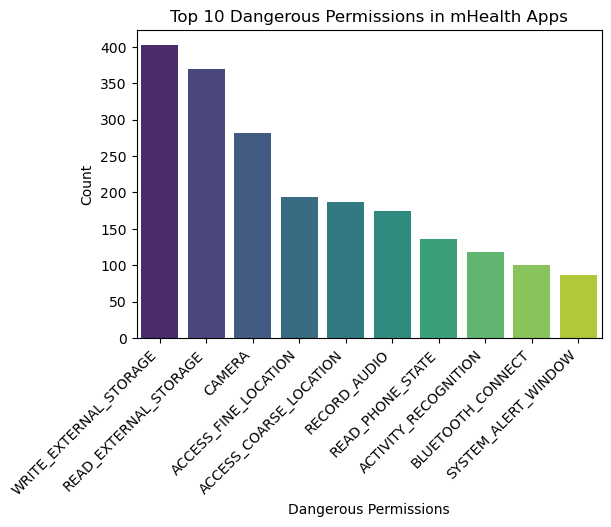

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract permission names and counts
permissions, counts = zip(*top_10_permissions)

# Set the figure size
plt.figure(figsize=(6, 4))

# Create a bar plot with flipped axes
sns.barplot(x=permissions, y=counts, hue=permissions, palette="viridis", legend=False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add labels and title
plt.ylabel("Count")
plt.xlabel("Dangerous Permissions")
plt.title("Top 10 Dangerous Permissions in mHealth Apps")

# Show the plot
plt.show()


In [10]:
# Count dangerous permissions for each region
usa_permissions = count_items(usa_df['permissions'], 'permissions')
europe_permissions = count_items(europe_df['permissions'], 'permissions')
rest_of_world_permissions = count_items(rest_of_world_df['permissions'], 'permissions')

usa_dangerous_permissions = count_items(usa_df['dangerous_permissions'], 'dangerous_permissions')
europe_dangerous_permissions = count_items(europe_df['dangerous_permissions'], 'dangerous_permissions')
rest_of_world_dangerous_permissions = count_items(rest_of_world_df['dangerous_permissions'], 'dangerous_permissions')

# Clean the permissions in each region
usa_dangerous_permissions = {clean_permission(k): v for k, v in usa_dangerous_permissions.items()}
europe_dangerous_permissions = {clean_permission(k): v for k, v in europe_dangerous_permissions.items()}
rest_of_world_dangerous_permissions = {clean_permission(k): v for k, v in rest_of_world_dangerous_permissions.items()}

# Clean up permissions by extracting only the part after "permission."
def clean_permission(permission):
    return permission.split('.')[-1].replace('!', '').strip()

# Function to get region-specific counts for top 10 permissions
def get_region_counts(top_permissions, region_permissions):
    return [region_permissions.get(clean_permission(perm), 0) for perm, _ in top_permissions]

# Extract top 10 dangerous permissions
permissions_counts = count_items(mhealth_apps['dangerous_permissions'], 'dangerous_permissions')

# Clean up permissions by extracting only the part after "permission."
cleaned_permissions_counts = {clean_permission(key): value for key, value in permissions_counts.items()}

# Sort permissions by count in descending order
sorted_permissions = sorted(cleaned_permissions_counts.items(), key=lambda item: item[1], reverse=True)
top_10_permissions = sorted_permissions[:10]

# Prepare data for the DataFrame outside the loop
data = {'Permission': [], 'US': [], 'EU': [], 'RoW': []}

# Print top 10 dangerous permissions with regional information
print("Top 10 Dangerous Permissions with Regional Information")
print("=" * 60)
for perm, count in top_10_permissions:
    usa_count = usa_dangerous_permissions.get(perm, 0)
    europe_count = europe_dangerous_permissions.get(perm, 0)
    row_count = rest_of_world_dangerous_permissions.get(perm, 0)
    total = usa_count + europe_count + row_count
    
    if total > 0:
        usa_counts = usa_count / total * count
        europe_counts = europe_count / total * count
        row_counts = row_count / total * count
    else:
        usa_counts = europe_counts = row_counts = 0

    print(f'{perm:<40} | USA: {usa_counts:<5} | Europe: {europe_counts:<5} | ROW: {row_counts:<5}')

    # Append the data for this permission to the list
    data['Permission'].append(perm)
    data['US'].append(usa_counts)
    data['EU'].append(europe_counts)
    data['RoW'].append(row_counts)

Top 10 Dangerous Permissions with Regional Information
WRITE_EXTERNAL_STORAGE                   | USA: 100.25853658536586 | Europe: 108.61341463414635 | ROW: 194.1280487804878
READ_EXTERNAL_STORAGE                    | USA: 91.12347354138399 | Europe: 97.63229308005428 | ROW: 180.24423337856174
CAMERA                                   | USA: 72.82149046793761 | Europe: 74.28769497400347 | ROW: 134.89081455805893
ACCESS_FINE_LOCATION                     | USA: 50.96332518337408 | Europe: 54.266503667481665 | ROW: 87.77017114914425
ACCESS_COARSE_LOCATION                   | USA: 50.743718592964825 | Europe: 52.15326633165829 | ROW: 84.10301507537689
RECORD_AUDIO                             | USA: 48.92307692307692 | Europe: 47.07692307692308 | ROW: 78.0 
READ_PHONE_STATE                         | USA: 34.0  | Europe: 34.507462686567166 | ROW: 67.49253731343283
ACTIVITY_RECOGNITION                     | USA: 28.260504201680675 | Europe: 32.72268907563026 | ROW: 57.016806722689076
BLUETOOT

<Figure size 600x400 with 0 Axes>

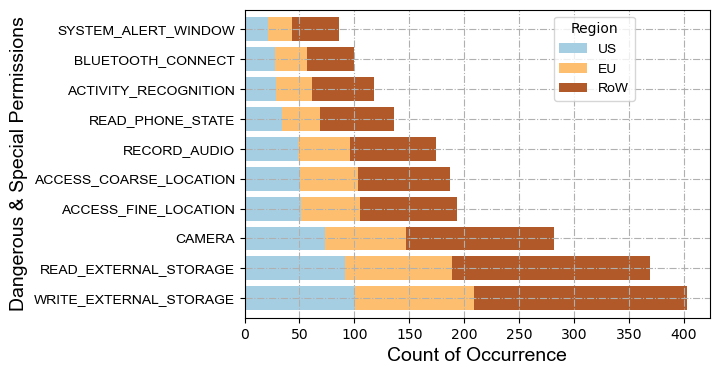

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the DataFrame after collecting all data
df_stacked = pd.DataFrame(data)

# Plot stacked bar chart
plt.figure(figsize=(6, 4))
df_stacked.set_index("Permission").plot(kind="barh", stacked=True, colormap="Paired", figsize=(6, 4), width=0.8)

# Customize plot with fancy font
plt.xlabel("Count of Occurrence", fontsize=14, fontweight='light', family='Arial')
plt.ylabel("Dangerous & Special Permissions", fontsize=14, fontweight='light', family='Arial')
plt.yticks(fontsize=10, rotation=0, family='Arial')

plt.grid(linestyle='-.')
plt.legend(title="Region", bbox_to_anchor=(0.65, 1), loc='upper left', prop={'family': 'Arial', 'weight': 'light'})

plt.savefig('../figures/permission_regional.png', bbox_inches='tight')

plt.show()



# Trackers

In [12]:
apps_tracker = mhealth_apps[mhealth_apps['trackers'].notnull()]
print(f'Number of apps with trackers: {len(apps_tracker)} ({len(apps_tracker)/len(mhealth_apps)*100:.2f}%)')

Number of apps with trackers: 563 (65.93%)


In [13]:
trackers_counts = count_items(unique_df['trackers'], 'trackers')
sorted_trackers = sorted(trackers_counts.items(), key=lambda item: item[1], reverse=True)

for key, value in sorted_trackers[:10]:
    print(f'{key:<80} {value}')

Google Firebase Analytics                                                        505
Google CrashLytics                                                               410
Facebook Login                                                                   248
Facebook Share                                                                   219
Facebook Analytics                                                               186
Google AdMob                                                                     174
AppsFlyer                                                                        121
Sentry                                                                           76
Google Analytics                                                                 73
Amplitude                                                                        72


In [14]:
print(len(trackers_counts))

153


In [15]:
trackers_counts

{'OpenTelemetry (OpenCensus': 18,
 'OpenTracing)': 18,
 'AltBeacon': 11,
 'Google CrashLytics': 410,
 'Google Firebase Analytics': 505,
 'Amazon Advertisement': 41,
 'Amplitude': 72,
 'Branch': 67,
 'Braze (formerly Appboy)': 19,
 'Brightcove': 6,
 'Facebook Analytics': 186,
 'Facebook Login': 248,
 'Facebook Share': 219,
 'Google AdMob': 174,
 'Google Analytics': 73,
 'Google Tag Manager': 65,
 'IAB Open Measurement': 66,
 'Split': 2,
 'Unity3d Ads': 29,
 'Facebook Ads': 68,
 'myTarget': 24,
 'AppsFlyer': 121,
 'Adobe Experience Cloud': 7,
 'Apptentive': 3,
 'MixPanel': 49,
 'Facebook Flipper': 17,
 'Sentry': 76,
 'Adjust': 48,
 'Instabug': 10,
 'Segment': 25,
 'Huawei Mobile Services (HMS) Core': 45,
 'OneSignal': 35,
 'GIPHY Analytics': 3,
 'Bugsnag': 21,
 'ACRA': 4,
 'AutoNavi / Amap': 5,
 'Microsoft Visual Studio App Center Analytics': 16,
 'Microsoft Visual Studio App Center Crashes': 16,
 'Qualtrics': 4,
 'Facebook Places': 41,
 'Mapbox': 4,
 'Salesforce Marketing Cloud': 9,
 'P

In [16]:
def count_unique_trackers(tracker_column):
    counts = []
    for items in tracker_column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


def calculate_category_stats(data, column_name):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        tracker_counts = count_unique_trackers(group[column_name])
        stats.append({
            "category": category,
            "mean_trackers": pd.Series(tracker_counts).mean(),
            "max_trackers": pd.Series(tracker_counts).max(),
            "median_trackers": pd.Series(tracker_counts).median(),
            "unique_trackers": len(extract_unique_item(group[column_name]))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df, 'trackers')
category_stats_sorted = category_stats.sort_values(by='unique_trackers', ascending=False)

top_5_categories = category_stats_sorted.head(5)
others = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_trackers = set()
for category, group in others.iterrows():
    others_unique_trackers.update(extract_unique_item(unique_df[unique_df['categories'] == group['category']]['trackers']))

others_summary = {
    "category": "Others",
    "mean_trackers": others["mean_trackers"].mean(),
    "max_trackers": others["max_trackers"].max(),
    "median_trackers": others["median_trackers"].median(),
    "unique_trackers": len(others_unique_trackers)
}

final_category_stats = pd.DataFrame([*top_5_categories.to_dict(orient='records'), others_summary])
final_category_stats

,category,mean_trackers,max_trackers,median_trackers,unique_trackers
0,Health & Fitness,6.275862,33.0,6.0,135
1,Medical,4.315789,12.0,4.0,70
2,Parenting,8.965517,30.0,8.0,64
3,Simulation,17.000000,31.0,17.0,35
4,Lifestyle,5.083333,12.0,5.5,26
5,Others,6.825926,22.0,4.5,58


In [17]:
import matplotlib.pyplot as plt


def extract_unique_items(dataframe):
    unique_items = set()
    for items in dataframe.dropna():
        unique_items.update(str(items).split(", "))
    return unique_items


def count_items(column):
    counts = []
    for items in column.dropna():
        counts.append(len(set(str(items).split(", "))))
    return counts


total_apps_queried = len(mhealth_apps)
unique_df = mhealth_apps.drop_duplicates(subset='app_id')
total_unique_apps = len(unique_df)


def calculate_category_stats(data):
    stats = []
    grouped = data.groupby('categories')
    for category, group in grouped:
        total_permissions = count_items(group['permissions'])
        dangerous_permissions = count_items(group['dangerous_permissions'])
        trackers = count_items(group['trackers'])

        stats.append({
            "category": category,
            "num_apps": len(group),
            "unique_permissions": len(extract_unique_items(group['permissions'])),
            "unique_dangerous_permissions": len(extract_unique_items(group['dangerous_permissions'])),
            "unique_trackers": len(extract_unique_items(group['trackers']))
        })
    return pd.DataFrame(stats)


category_stats = calculate_category_stats(unique_df)

category_stats_sorted = category_stats.sort_values(by='num_apps', ascending=False)

top_categories = category_stats_sorted.head(5)
other_categories = category_stats_sorted.tail(len(category_stats_sorted) - 5)

others_unique_permissions = set()
others_unique_dangerous_permissions = set()
others_unique_trackers = set()

for _, row in other_categories.iterrows():
    others_unique_permissions.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['permissions']))
    others_unique_dangerous_permissions.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['dangerous_permissions']))
    others_unique_trackers.update(extract_unique_items(mhealth_apps[mhealth_apps['categories'] == row['category']]['trackers']))

others = {
    "category": "Others",
    "num_apps": other_categories["num_apps"].sum(),
    "unique_permissions": len(others_unique_permissions),
    "unique_dangerous_permissions": len(others_unique_dangerous_permissions),
    "unique_trackers": len(others_unique_trackers)
}

category_stats_final = pd.DataFrame([*top_categories.to_dict(orient="records"), others])
category_stats_final.head(10)

,category,num_apps,unique_permissions,unique_dangerous_permissions,unique_trackers
0,Health & Fitness,536,870,50,135
1,Medical,180,286,22,70
2,Parenting,43,112,15,64
3,Education,25,61,13,22
4,Lifestyle,24,97,17,26
5,Others,46,173,26,62


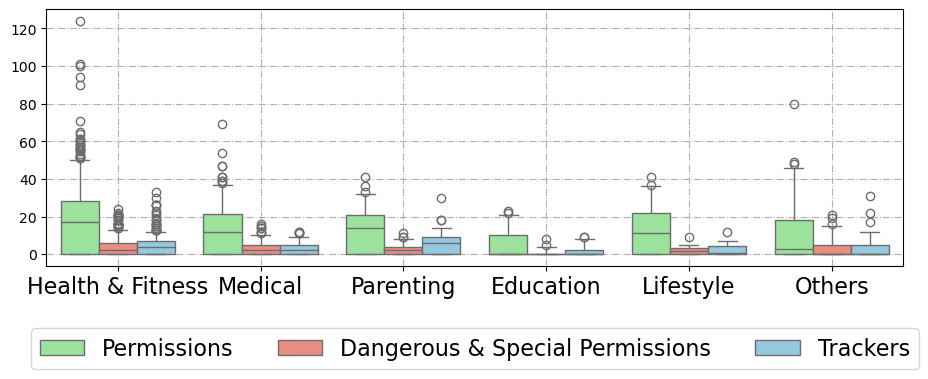

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mhealth_apps = pd.read_csv("../data/mhealth_apps.csv")

category_counts = mhealth_apps['categories'].value_counts()
top_categories = category_counts.nlargest(5).index

mhealth_apps['categories'] = mhealth_apps['categories'].apply(
    lambda x: x if x in top_categories else "Others"
)

category_order = category_counts.loc[top_categories].index.tolist() + ["Others"]

melted_data = mhealth_apps.melt(
    id_vars="categories",
    value_vars=["num_permissions", "num_dangerous_permissions", "num_trackers"],
    var_name="Metric",
    value_name="Value"
)

palette = ["lightgreen", "salmon", "skyblue"]

plt.figure(figsize=(10, 4))

sns.boxplot(
    data=melted_data,
    x="categories", 
    y="Value",   
    hue="Metric",
    order=category_order,
    palette=palette,
    whis=[5, 95],
    hue_order=["num_permissions", "num_dangerous_permissions", "num_trackers"]  # Hue order for legend
)

handles, _ = plt.gca().get_legend_handles_labels()

plt.ylabel("", fontsize=14) 
plt.xlabel("", fontsize=14)  
plt.legend(
    handles=handles, 
    labels=["Permissions", "Dangerous & Special Permissions", "Trackers"], 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.2), 
    ncol=3,
    fontsize=16 
)
plt.grid(linestyle='-.')
plt.xticks(fontsize=16)

plt.tight_layout()
plt.savefig('../figures/permission_and_trackers.png', bbox_inches='tight')

plt.show()
